# HW 2: Generative Models

This homework is about proposing a model to generate a given dataset.

### Part 1: Visualising the Dataset

The code below visualises the dataset, given in dataset.txt:

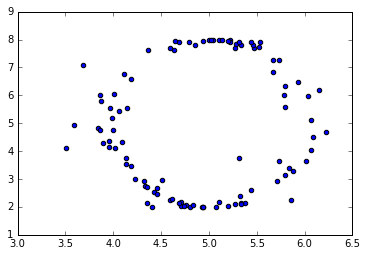

In [58]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


N_input = 100 # number of data points
file = open("dataset.txt")
X1_in = [] 
X2_in = [] # initialize empty lists for the two dimensions
for i in range (0,N_input): # loop over the N data points
    line = file.readline()
    X1_in.append(line.split()[0]) # append first part of the line to X1
    X2_in.append(line.split()[1]) 
# the lists are now full

plt.scatter(X1_in,X2_in)
plt.show()

The above looks like the boundary of an ellipse centered at (5,5), with horizontal axis length 2 and vertical axis length 6. Several outliers exist and we might be a little off with the exact values, but this seems to be the best elliptical fit to the data (if the fit is elliptical). 

### Part 2: Proposing a Generative Model

Thus, generating points from the ellipse

$\frac{{(x-5)}^2}{1^2} + \frac{{(y-5)}^2}{3^2} = 1$

will generate the desired points.

Additionally, to account for the noise, we may add to each point a minor error factor $\epsilon$

The error of each single sampled point above can be calculated roughly as follows:

If the point $(x,y)$ was exactly on the ellipse, then $\frac{{(x-5)}^2}{1^2} + \frac{{(y-5)}^2}{3^2} - 1$ would be 0.
The left hand side of the equation above can serve as our square-error function heuristically. Then, we will just assume that the error is radial. This is very biased, but nonetheless it is still possible to generate every point in $\mathbb{R}^2$ via this method! (Pick point on ellipse -> Pick random error radially.)

Below is a calculation of errors:

In [78]:
def error(x, y):
    x = eval(x)
    y = eval(y) # somehow Python wants type-checking before the next step
    squareError = (x-5)*(x-5) + (y-5)*(y-5)/9 - 1
    if(squareError < 0): # point inside ellipse
        error = -(np.sqrt(-squareError))
    else: # point on or outside ellipse
        error = np.sqrt(squareError)
    return error

Errors = [] # matrix of errors
for i in range(0, N_input):
    Errors.append(error(X1_in[i], X2_in[i]))

# we now have a full list of errors
# get mean error and standard deviation

mu = np.mean(Errors)
sigma = np.std(Errors)

0.100569679459 0.371881959492


We have now calculated the radial error. Assuming it is normally distributed, we can now sample from the normal distribution $N(\mu, \sigma^2)$ to generate a random error each time we generate a point.

### Part 3: Implementing the Generative Model

However, there is still the question of how to implement the above idea. First, how do we generate points from the ellipse? Let's try generating x-values, and calculate y-values accordingly. Since there will be two y's for each x, we flip a coin to decide whether the y-values are going to be on the bottom half or the top half of the ellipse. The code is given below.

Solving the ellipse equation for y yields:

$(y-5)^2 = [1 - (x-5)^2] * 3^2$

So after generating x, we can flip a coin for (y-5) and act accordingly.

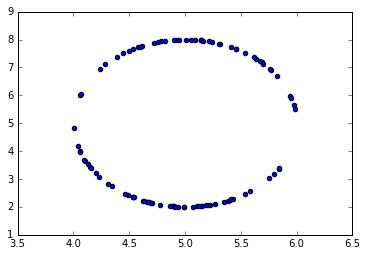

In [56]:
N = 100 # number of output points
X1_out = np.random.rand(N) # get N random X-values between 0 and 1
X2_out = [] # the actual y-values to be filled

for i in range(0,N):
    X1_out[i] = (X1_out[i]*2)+4 # redistribute X-values across (4, 6)

for i in range(0,N):
    
    coin = np.random.randint(0,2) # 0 - below the axis, 1 - above the axis
    y = np.sqrt((1-(X1_out[i]-5)*(X1_out[i]-5)) * 9) # calculate y-5 values
    if(coin == 0):
        y = -y # flip if necessary
    y = y+5
    X2_out.append(y)
    

plt.scatter(X1_out, X2_out)
plt.show()

However, the output is very sparse around the edges of the major axis, since choosing X-values does not account for the "curvature" - if this was projected to the X-axis, the distribution would be uniform, but "expanding" the ellipse ruins it. We may work around this by flipping a coin at each step: whether to generate X-values from the Y-values, or vice-versa.

To calculate x-values from y-values, again solving the ellipse equation yields:

$(x-5)^2 = 1 - \frac{(y-5)^2}{9}$

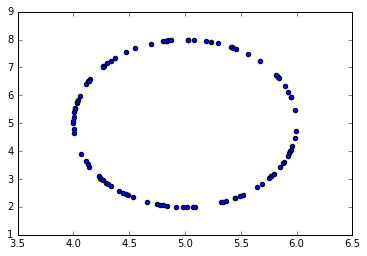

In [108]:
Randoms = np.random.rand(N) # generate N different RV's to sample X or Y (decided later)
X1_out = [] # clean the lists
X2_out = []

for i in range(0,N):
    coin = np.random.randint(0,2) # 0 - generate X first, 1 - generate Y first
    if(coin == 0): # generate X first
        X1_out.append(Randoms[i]*2 + 4) # redistribute X-values along (4, 6)
        y = np.sqrt((1-(X1_out[i]-5)*(X1_out[i]-5)) * 9) # calculate y-5 values
        coin = np.random.randint(0,2) # 0 - below the axis, 1 - above the axis
        if(coin == 0):
            y = -y # flip if necessary
        y = y+5
        X2_out.append(y)
    else: # generate Y first
        X2_out.append(Randoms[i]*6 + 2) # redistribute Y-values across (2, 8)
        x = np.sqrt (1 - (X2_out[i] - 5)*(X2_out[i] - 5) / 9) # calculate x-5 values
        coin = np.random.randint(0,2) # 0 - left side, 1 - right side
        if (coin == 0):
            x = -x
        x = x+5
        X1_out.append(x)

plt.scatter(X1_out, X2_out)
plt.show()

The above sample seems more evenly distributed, so we'll stick with that. Now to add errors:
We'll sample from the normal distribution $N(0, \sigma^2)$ and then go some distance radially according to the sampled error. A sample of 0 corresponds to no error, and a sample of 1 corresponds to going exactly 1 "radius" in that direction. Of course, "radius" here corresponds to the length of the line segment between (5, 5) and our sampled point, so its value depends on the sampled point! A negative error represents going that far towards the *inside* of the ellipse.

The below code adds appropriate error to the points already generated above.

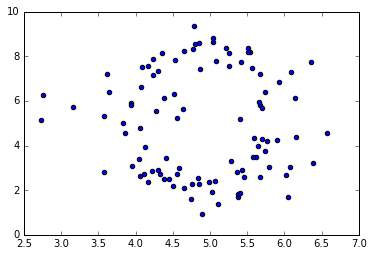

In [112]:
X1_outWithError = []
X2_outWithError = []

def addError(x, y):
    theta = np.arctan2(y-5, x-5) # find angle from center of ellipse
    error = sigma * np.random.randn() + mu # sample error
    return (x+error*np.cos(theta), y+error*np.sin(theta)) # return updated points

for i in range(0, 100):
    newValues = addError(X1_out[i], X2_out[i])
    X1_outWithError.append(newValues[0])
    X2_outWithError.append(newValues[1])

plt.scatter(X1_outWithError, X2_outWithError)
plt.show()

This seems much more noisy than the original to the naked eye! The heuristic seems to be not working properly. Also, perhaps setting the mean error to be non-zero was not the best idea.

### Part 4: Visual Comparison of Generative Algorithms with Input

In any case, below is a graph where all three sets of data are visible (initial data, perfect ellipse, ellipse with error):

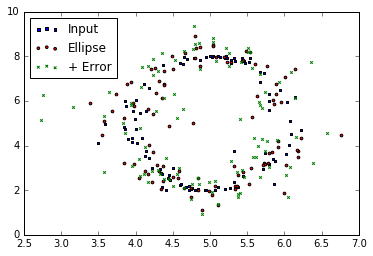

In [123]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X1_in, X2_in, s=7, c='b', marker="s", label='Input')
ax1.scatter(X1_out, X2_out, s=7, c='r', marker="o", label='Ellipse')
ax1.scatter(X1_outWithError, X2_outWithError, s=7, c='g', marker="x", label='+ Error')
plt.legend(loc='upper left')
plt.show()

It seems that the perfect ellipse suited it better. Even if the error function works correctly, a sample generated with artificial error might be drastically different than the input due to error propagation (some points are, in a way, "two errors" away from each other in two error-riddled distributions).

### Part 5: Discussion on "Similarity of Datasets"

How can we tell if two datasets are similar? If they contain the same number of points (as they do in this simulation), we can define the distance to be the sum of closest point pairs. In more rigorous notation, given two sets $A = \{a_1, \ldots, a_n\}$ and $B = \{b_1, \ldots, b_n\}$, we can define their distance $d(A, B)$ to be the sum:

$\sum\limits_{i=1}^{n} \|a_i - b_i\|$

Of course, this sum depends on the ordering of the sets. Since there are a finite number ($n^2$) of pairs of orderings, we define the distance to be the *minimum* of these values (i.e. choose the best ordering that gets close points to close indices, then measure).

Of course, minimizing over 10000 different distributions in this case is tedious. Below is a greedy algorithm that assigns to each point the closest neighbour in the other data set. Since this greedy algorithm will by nature blow up the last few distances, we only consider 90 pairs of the 100 points (to get rid of the greedy part's effects).

In [147]:
## Distance between two points (x,y) and (z,t)
def distance(x, y, z, t):
    x = float(x)
    y = float(y)
    z = float(z)
    t = float(t) # This is what happens when you don't parse properly
    return (np.sqrt((x-z)*(x-z) + (y-t)*(y-t)))

## Greedy calculation of distance between two sets of points (Xfirst, Yfirst) and (Xsecond, Ysecond)
## Lists are assumed to be 100 long, and the distance is calculated over the first 90 points
def calculateDistance(Xfirst, Yfirst, Xsecond, Ysecond):
    X1 = []
    Y1 = []
    X2 = []
    Y2 = []
    totalDistance = 0
    # get an exact copy of lists to operate on - don't want to pop original lists
    for i in range(0, 90):
        X1.append(Xfirst[i])
        Y1.append(Yfirst[i])
        X2.append(Xsecond[i])
        Y2.append(Ysecond[i])
    for i in range(90, 100): ## keep the second list longer - we'll be popping from the first list
        X2.append(Xsecond[i])
        Y2.append(Ysecond[i])
    while(len(X1) > 0):
        x1 = X1.pop()
        y1 = Y1.pop() ## get pair of points
        minDist = np.inf
        currentIndex = 0
        for i in range(0, len(X2)):
            dist = distance(x1, y1, X2[i], Y2[i])
            if(dist < minDist):
                minDist = dist
                currentIndex = i
        ## found closest point, pop it
        X2.pop(currentIndex)
        Y2.pop(currentIndex)
        totalDistance = totalDistance + minDist
    return totalDistance/90

print("Greedy average distance of input to ellipse: " + str(calculateDistance(X1_in, X2_in, X1_out, X2_out)))
print("Greedy average distance of input to ellipse with error: " + str(calculateDistance(X1_in, X2_in, X1_outWithError, X2_outWithError)))


Greedy average distance of input to ellipse: 0.387539797326
Greedy average distance of input to ellipse with error: 0.42249504621


As expected above, the generative algorithm that included artificial noise did worse.